# DataLab task 3 

### Plant instance segmentation 

### Deliverables:
- The code (task_3.ipynb), with comments/docstrings explaining each step. 
- The notebook should display the output of the code on task_3_image_1.png and task_3_image_2.png.
### Client Requirements
- Your code should only rely on traditional computer vision methods. In other words, do not use an ML/DL model.
- The quality of the segmentation will be qualitatively assessed by comparing it to Figure 3.1
- The code should work for at least task_3_image_1.png and task_3_image_2.png.
- An output similar to Figure 3.1 is shown in task_3.ipynb for the images task_3_image_1.png and task_3_image_2.png.

#### Imports 

I keep all my imports on top of all the other cells in order to keep track of what's imported and to ensure that I don't the same thing twice 

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np 

#### The function 

In the task 3 evidencing notebook I started this task by just writing lines of code and I didn't define a function. After I was sattisfies with everything I turned it into a function and altered minor details so it generalizes to both images. 

The process_image function contains: 
- image_path: which is the path that I want to process.
- roi_coords: defines the region of interest in the image. The default ROI for this function is (0, 125, 3000, 1500) this is because after some trial and error I realized that y = 125 works perfect for both images because a lower value includes unnecessary noise.
- edge_thickness: I set the value to None so the function itself can decide the edge thickness based on the ROI. 
- min_contour_area: I also set this value to None so it can dynamically calculate a default value which is based on yhe size of the ROI
- min_component_ratio = the default value for this is 0.001 but further on when I'm calling the funtion I change the ratio based on what works best for each image. I put the default to 0.001 so it has a starting value. 

##### Loading the image 
I used the basic code that was shown to us in the self-study notebooks. It loads the specified image path in grayscale. 

##### ROI
I defined a region of interest so it only focuses on a specific part of the image, because the little blob at the bottom of the images was causing trouble when I was displaying the largest components. Because I hardcoded the ROI, I added the "min(w, width - x), min(h, height - y)" to ensure that the if the ROI extends the image dimensions it gets cropped to fit within the image. 

#### Default parameter handling 
To ensure that the function adapts to different image sizes, I created dynamic values so if no edge thickness or minimum contour are is provided it it is set to 5% of the smallest dimension of the ROI and 0.1% of the total area of the ROI respectively. 

#### Image preprocessing 
Thresholding: I used Gaussian blur to reduce image noise, because that was shown in the notebook. Some of my fellow classmates used adaptive thresholding so I looked into different ones and saw that adaptive thresholding works best for images with varying lighting conditions, which is perfect for the petri dishes. The values 61 and 5 were chosen after multiple iterations, for the second image the roots were not connecting properly so I played around a lot with these two values and this works the best for me. 

Cleaned: I used morphological closing to fill in the small holes within the objects and dilation to expand the white areas to ensure close components are connected to a larger component

Edges: To remove the outer border of the images I used masks this removes the pixels on the edge so that we can focus on the relevant features. 

#### Connected components 
This identifies the connected components in the preprocessed images and filters out the components which are smaller than the specified minimum component ratio. 

#### Assembling output
In this step I replace the ROI in the original image with the processed version which will allows it to be displayed with the full image. 

##### Displaying results
I created a plots with 3 subplots for easy visualization of the stages, the first being the original image, then the thresholded image of the ROI, and lastly, the final version which depicts the 5 largest components in the ROI. 

#### Using the function
I called the "process_image" function and put the relative path to my images and I also changed the minimum component ratio. The default one wasn't working that great with the images so I played around with different values to see which fit the images the best, which for both is 0.00055. 

#### Final output
For the deliverable I just used the same line of code that was given to us in the notebook which displays the labels of the final output image.







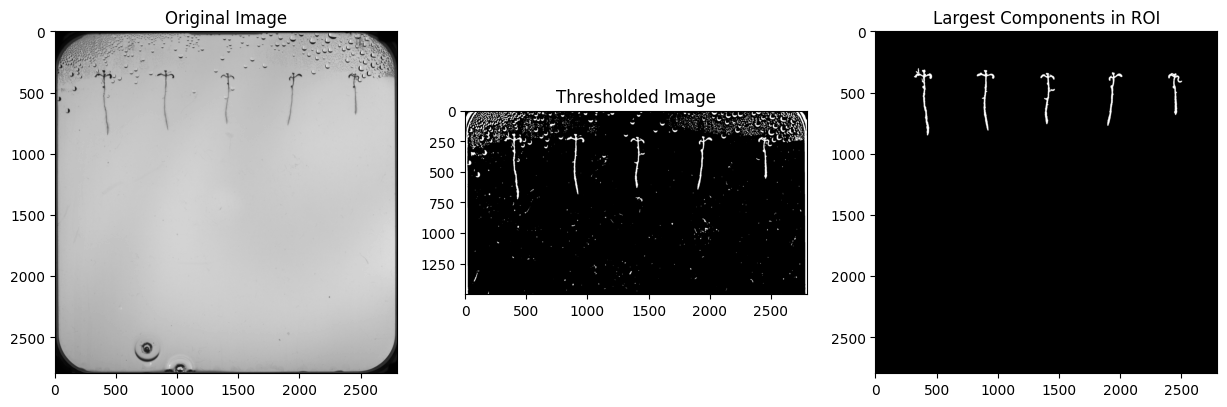

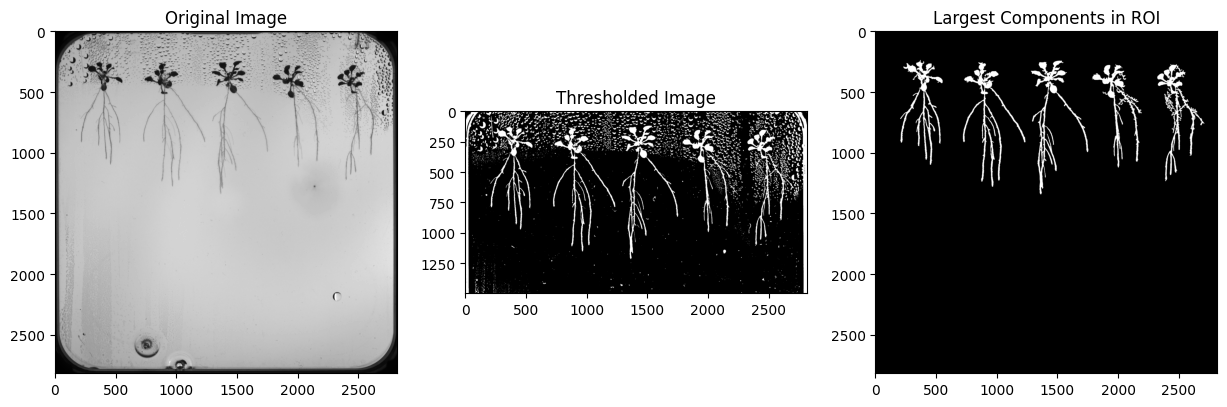

In [15]:
def process_image(image_path, roi_coords=(0, 125, 3000, 1500), edge_thickness=None, min_contour_area=None, min_component_ratio=0.001):
    # Loading image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # ROI
    height, width = img.shape
    x, y, w, h = roi_coords
    w, h = min(w, width - x), min(h, height - y)  
    roi = img[y:y+h, x:x+w]  
    
    # Default values
    edge_thickness = edge_thickness or int(0.05 * min(roi.shape[:2]))
    min_contour_area = min_contour_area or 0.001 * roi.size

    # Thresholding, blur, and clean the image
    thresholded = cv2.adaptiveThreshold(cv2.GaussianBlur(roi, (3, 3), 0), 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                       cv2.THRESH_BINARY_INV, 61, 5)
    cleaned = cv2.dilate(cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8)), 
                         np.ones((3, 3), np.uint8), iterations=1)
    mask = np.zeros_like(cleaned)
    mask[edge_thickness:-edge_thickness, edge_thickness:-edge_thickness] = 255 
    cleaned = cv2.bitwise_and(cleaned, mask)

    # Connected components analysis and filtering
    _, labels, stats, _ = cv2.connectedComponentsWithStats(cleaned)
    largest_indices = np.where(stats[1:, cv2.CC_STAT_AREA] > min_component_ratio * roi.size)[0] + 1

    # Output image with largest components
    output_img = np.zeros_like(cleaned)
    for idx in largest_indices:
        output_img[labels == idx] = 255 

    # Place processed ROI back into the full image
    full_output_img = np.zeros_like(img)
    full_output_img[y:y+h, x:x+w] = output_img

    # Displaying results
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 3, 1), plt.imshow(img, cmap='gray'), plt.title('Original Image')
    plt.subplot(1, 3, 2), plt.imshow(thresholded, cmap='gray'), plt.title('Thresholded Image')
    plt.subplot(1, 3, 3), plt.imshow(full_output_img, cmap='gray'), plt.title('Largest Components in ROI')
    plt.show()

    return full_output_img, labels

# Usage
output_img1, labels1 = process_image('cropped_image_1.png', min_component_ratio=0.00055)
output_img2, labels2 = process_image('cropped_image_2.png', min_component_ratio=0.00055)


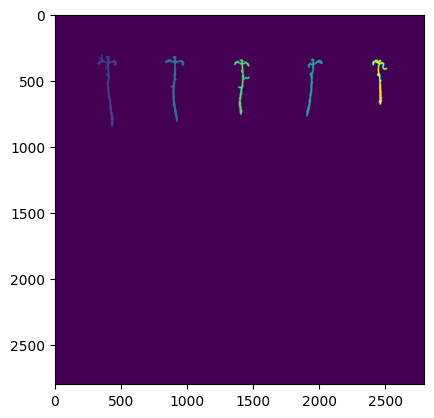

In [16]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_img1)
plt.imshow(labels)

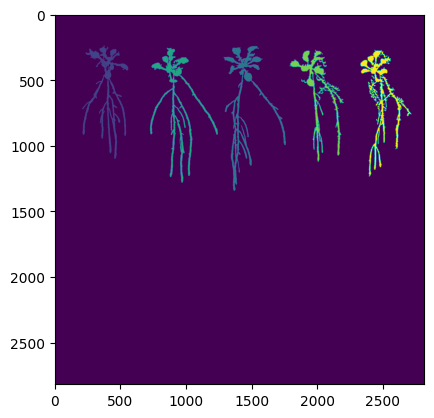

In [17]:
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(output_img2)
plt.imshow(labels)